In [2]:
import os
import random
from tqdm import tqdm


import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.utils import load_img, array_to_img, img_to_array
from keras.models import Model, load_model
from keras.layers import Input, Activation, SeparableConv2D, BatchNormalization, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

from skimage.io import imshow

import matplotlib.pyplot as plt 


## Création du dataset

In [3]:
def silos_present(mask_array):
    return sum(sum(sum(mask_array)))

In [4]:
IMG_WIDTH_HEIGHT = 256
IMG_CHANNELS = 3
classes = 1

In [5]:
path = "ai_ready/"
input_dir = path + 'images/'
target_dir = path + 'masks/'

In [6]:
input_img_paths = sorted(
    [
        fname
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        fname
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

In [7]:
len(target_img_paths)

1999

In [8]:
N = len(input_img_paths)
X = []
Y = []

for i in tqdm(range(N)):
    img_path = input_img_paths[i]
    if os.path.isfile(input_dir + img_path) and os.path.isfile(target_dir + img_path):
        img = load_img(input_dir + img_path, grayscale=False,target_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT)) #imread(img_path)[:,:,:3] #.astype("float32") #/ 255.0 -> is done by rgb2gray
        img = img_to_array(img)
        X.append(img.astype('float32') / 255.0)

        #mask_path = target_img_paths[i]
        mask = load_img(target_dir + img_path, color_mode = "grayscale",target_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT)) #imread(img_path)[:,:,:3] #.astype("float32") #/ 255.0 -> is done by rgb2gray
        mask = img_to_array(mask)
        Y.append(mask // 200)
        
X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.uint8)

100%|██████████| 1999/1999 [00:30<00:00, 65.26it/s]


In [9]:
Y2 = []
X2 = []
for i in range(len(Y)):
    if silos_present(Y[i]):
        Y2.append(Y[i])
        X2.append(X[i])
X2 = np.array(X2, dtype=np.float32)
Y2 = np.array(Y2, dtype=np.uint8)

In [10]:
train_test_split = int(len(X2)*0.8)
X_train = X2[:int(train_test_split*0.8)]
Y_train = Y2[:int(train_test_split*0.8)]

X_val = X2[int(train_test_split*0.8):]
Y_val = Y2[int(train_test_split*0.8):]

X_test = X2[train_test_split:]
Y_test = Y2[train_test_split:]

245


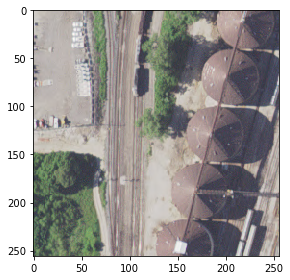

/opt/conda/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


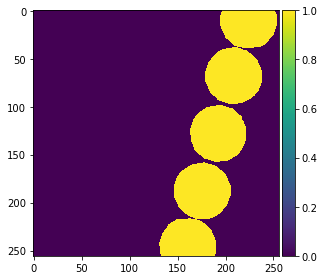

In [11]:
i = random.randint(0, len(X_train))
print(i)
imshow(X_train[i])
plt.show()
imshow(np.squeeze(Y_train[i]))
plt.show()

## Data Augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
BATCH_SIZE = 16

# we create two instances with the same arguments
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='constant')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Keep the same seed for image and mask generators so they fit together
seed = 42

x=image_datagen.flow(X_train,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train,batch_size=BATCH_SIZE,shuffle=True, seed=seed)


# Creating the validation Image and Mask generator
image_datagen_val = ImageDataGenerator()
mask_datagen_val = ImageDataGenerator()

image_datagen_val.fit(X_val, augment=True, seed=seed)
mask_datagen_val.fit(Y_val, augment=True, seed=seed)

x_val=image_datagen_val.flow(X_val,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_val,batch_size=BATCH_SIZE,shuffle=True, seed=seed)

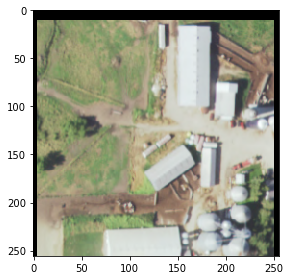

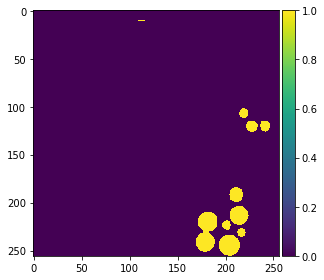

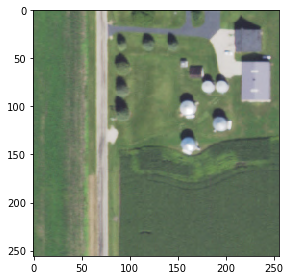

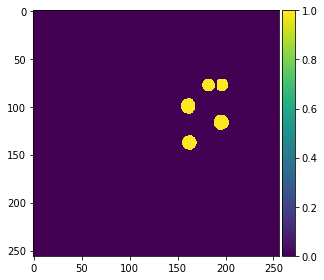

In [14]:
imshow(x.next()[0])
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
imshow(x_val.next()[0])
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [15]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

## UNet Model

In [16]:
def convolutional_block(inputs=None, n_filters=32, dropout_prob=0.1, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)
   
    

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    conv = BatchNormalization()(conv)
    skip_connection = conv
    
    return next_layer, skip_connection

In [17]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    return conv

In [18]:
def unet_model(input_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT
                           , IMG_CHANNELS), n_filters=32, n_classes=3):
    
    inputs = Input(input_size)
    
    #contracting path
    cblock1 = convolutional_block(inputs, n_filters)
    cblock2 = convolutional_block(cblock1[0], 2*n_filters)
    cblock3 = convolutional_block(cblock2[0], 4*n_filters)
    cblock4 = convolutional_block(cblock3[0], 8*n_filters, dropout_prob=0.2) 
    cblock5 = convolutional_block(cblock4[0],16*n_filters, dropout_prob=0.2, max_pooling=None)     
    
    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_classes,
                 1,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same', activation = 'sigmoid')(conv9) 
    #conv10 = Activation('sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [19]:
unet = unet_model((IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, IMG_CHANNELS), n_classes=1)
unet.summary()

2022-12-07 21:53:24.958321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 21:53:24.970580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 21:53:24.971677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 21:53:24.973531: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

## Training & Prediction

In [27]:
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

## Creation of custom metrics and losses

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1 - tf.divide(nominator, denominator)
        return result
    
def IoU_coeff(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean(
        (2.0 * intersection + smooth) / (union - intersection + smooth), axis=0
    )
    
def IoULoss(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(K.dot(targets, inputs))
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return 1 - IoU

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD

In [62]:
from keras.models import load_model
#Creation or loading of the model.
unet = unet_model()
#unet = load_model('best_model.hdf5',compile=False,custom_objects={'dice_coef': dice_coef, 'IoU_coeff': IoU_coeff, 'DiceLoss':  DiceLoss, 'IoULoss': IoULoss})
unet.compile(optimizer=Adam(learning_rate=0.0001),
             loss=DiceLoss(), 
             metrics=[dice_coef,IoU_coeff])

In [63]:
EPOCHS = 30

model_checkpoint = ModelCheckpoint('unet_silos.hdf5', monitor='val_loss',verbose=1, save_best_only=True)

earlystopper = EarlyStopping(monitor="val_loss", 
                      mode="min", verbose= 1,
                      patience=15,restore_best_weights=True)
                             
#reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
#                                  patience=3, 
#                                 verbose=1, mode='max', cooldown=2, min_lr=1e-6)



model_history = unet.fit_generator(train_generator, validation_data=val_generator,
                         validation_steps=10, steps_per_epoch=80,
                         epochs=EPOCHS,
                         callbacks=[earlystopper,model_checkpoint])

/tmp/ipykernel_540/565321825.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = unet.fit_generator(train_generator, validation_data=val_generator,


Epoch 1/30
80/80 [==============================] - ETA: 0s - loss: 0.5449 - dice_coef: 0.1861 - IoU_coeff: 0.2324
Epoch 00001: val_loss improved from inf to 0.56991, saving model to unet_silos.hdf5
80/80 [==============================] - 21s 240ms/step - loss: 0.5449 - dice_coef: 0.1861 - IoU_coeff: 0.2324 - val_loss: 0.5699 - val_dice_coef: 0.1047 - val_IoU_coeff: 0.1182
Epoch 2/30
80/80 [==============================] - ETA: 0s - loss: 0.3389 - dice_coef: 0.2966 - IoU_coeff: 0.3852
Epoch 00002: val_loss did not improve from 0.56991
80/80 [==============================] - 18s 229ms/step - loss: 0.3389 - dice_coef: 0.2966 - IoU_coeff: 0.3852 - val_loss: 0.7741 - val_dice_coef: 0.0966 - val_IoU_coeff: 0.1072
Epoch 3/30
80/80 [==============================] - ETA: 0s - loss: 0.2837 - dice_coef: 0.3147 - IoU_coeff: 0.4174
Epoch 00003: val_loss improved from 0.56991 to 0.34049, saving model to unet_silos.hdf5
80/80 [==============================] - 19s 237ms/step - loss: 0.2837 - dic

In [73]:
unet.evaluate(X_train,Y_train)

20/20 [==============================] - 1s 60ms/step - loss: -0.2125 - dice_coef: 0.6395 - IoU_coeff: 1.0390


[-0.21246081590652466, 0.6394651532173157, 1.0390361547470093]

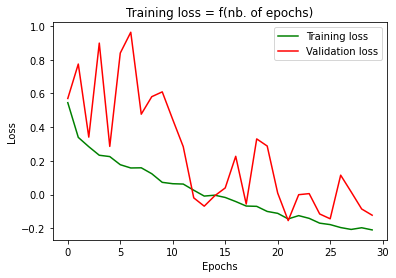

In [91]:
plt.plot(model_history.epoch, model_history.history["loss"], "g", label="Training loss")
plt.plot(
    model_history.epoch, model_history.history["val_loss"], "r", label="Validation loss"
)
plt.title("Training loss = f(nb. of epochs)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

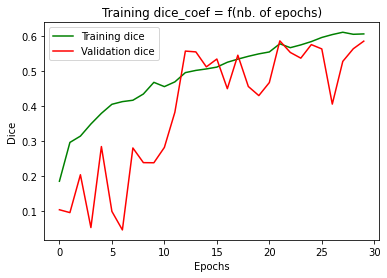

In [90]:
plt.plot(
    model_history.epoch, model_history.history["dice_coef"], "g", label="Training dice")
plt.plot(model_history.epoch,model_history.history["val_dice_coef"],"r",label="Validation dice")
plt.title("Training dice_coef = f(nb. of epochs)")
plt.xlabel("Epochs")
plt.ylabel("Dice")
plt.legend()
plt.show()

## Predictions on the testing set

In [76]:
model = load_model('best_model.hdf5',compile=False,custom_objects={'dice_coef': dice_coef, 'IoU_coeff': IoU_coeff, 'DiceLoss':  DiceLoss, 'IoULoss': IoULoss})

In [79]:
predictions = model.predict(X_test)


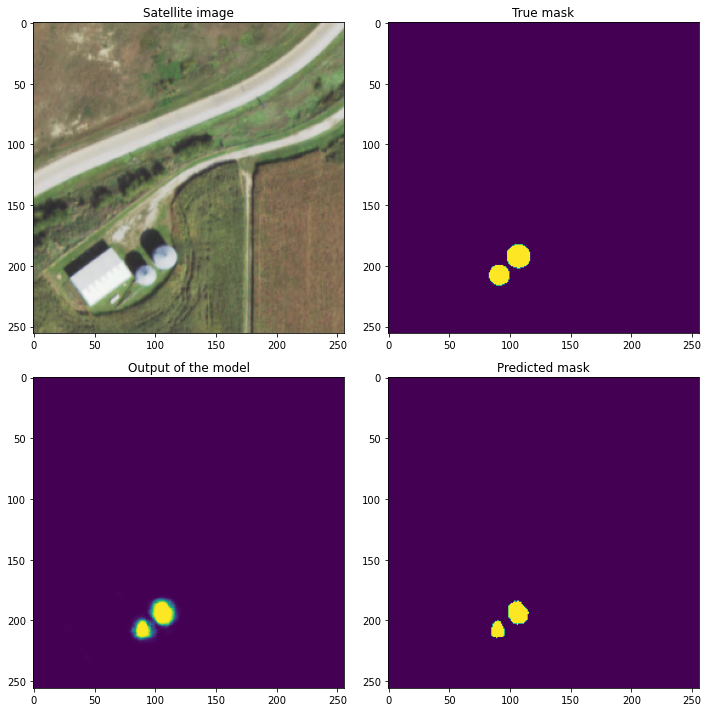

In [83]:
THRESHOLD = 0.6
i = 132

fig, axs = plt.subplots(2,2,figsize=(10, 10))

axs[0][0].imshow(X_test[i])
axs[0][0].set_title("Satellite image")

axs[0][1].imshow(np.squeeze(Y_test[i]))
axs[0][1].set_title("True mask")

axs[1][0].imshow(np.squeeze(predictions[i]))
axs[1][0].set_title("Output of the model")

axs[1][1].imshow(np.squeeze(np.array(predictions[i]>THRESHOLD, dtype=np.uint8)))
axs[1][1].set_title("Predicted mask")
fig.tight_layout()